# Self-Balancing Scooter Control

![](images/self-balancing-scooter.png)

> A self-balancing scooter [...] is a self-balancing personal transporter consisting of two motorized wheels connected to a pair of articulated pads on which the rider places their feet. The rider controls the speed by leaning forward or backward, and direction of travel by twisting the pads.
> 
> Source: <https://en.wikipedia.org/wiki/Self-balancing_scooter>

### Python Dependencies

In [1]:
#this is the first change 



from numpy import *
from numpy.linalg import *

from scipy.linalg import *
from scipy.integrate import *
from scipy.signal import *

from matplotlib.pyplot import *

Step 1 - Scooter Planar Model
================================

### Introduction

We consider a simple model of a self-balancing scooter evolving in the plane. It is mainly made of

  - The frame that contains the two articulated pads; from above, each pad essentially look like a triangle (one vertice in the center of the frame, one vertice at each extremity of the wheel).

  - Two fixed wheels (their orientation with respect to the frame does not change). 
    They are parallel and located at opposite ends of the frame. 
    
Let $(0, e_x, e_y)$ be a direct orthonormal frame of the plane. We denote 

  - $(x, y)$ the coordinates of the wheel axis center in the orthonormal and 
  - $\theta$ the angle of the wheels direction with respect to vector $e_x$ ; with $\theta = 0$ when the front of the scooter faces the right ($e_x$) and $\theta = \pi/2$ when it faces upwards ($e_y$).

  - $\phi_l$ and $\phi_r$ the rotation angles of the left and right wheel respectively ; by convention, when these angles increase, the scooter moves forward.

### Parameter Definition

From now on, we assume that the seat frame length is $\ell = 50 \mbox{ cm}$ and the wheel radius is $r = 12.5 \mbox{ cm}$.

🧩 Define the corresponding Python variables `l` and `r` (express every length in meters, and more generally in the sequel, always use the [international standard of units](https://en.wikipedia.org/wiki/SI_derived_unit)) for numerical values. 

In [2]:
l = 0.5  # length in meters
r = 0.125  # radius in meters

### Graphical Representation

🧩 Implement a function `draw_scooter` with arguments `x`, `y` and `theta` that draws a simple geometric model of the wheelchair (with a red frame and black fixed wheels) in the plane (top view) for arbitrary values of $(x, y)$ and $\theta$. Use a green circle marker 50 cm in of the frame to indicate which way is forward.

🗝️ **Hint.** Use the function `plot` of `matplotlib.pyplot`.

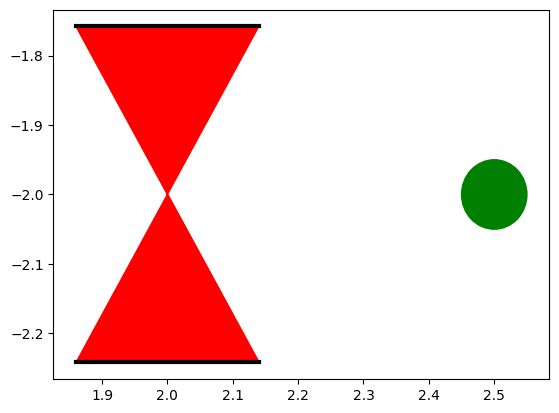

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def draw_scooter(x, y, theta):

    x_C=x
    y_C=y
    # Calcul de la hauteur du triangle
    h = np.sqrt((l/2)**2 + r**2)

    # Calcul des angles pour les sommets du triangle
    gamma = theta - np.pi / 6
    gamma1 = theta + np.pi / 6

    # Calcul des coordonnées des sommets du triangle
    x1 = x + h * np.sin(gamma)
    y1 = y - h * np.cos(gamma)

    x2 = x + h * np.sin(gamma1)
    y2 = y - h * np.cos(gamma1)

    x3 = x - h * np.sin(gamma)
    y3 = y + h * np.cos(gamma)

    x4 = x - h * np.sin(gamma1)
    y4 = y + h * np.cos(gamma1)

    # Coordonnées des sommets du triangle
    x_L = [x2, x1, x3, x4]  # Coordonnées x des sommets
    y_L = [y2, y1, y3, y4]  # Coordonnées y des sommets

    x= [x,x,x,x]
    y=[y,y,y,y]
    # Tracer les lignes du triangle
    plt.plot(x + [x_L[0]], y + [y_L[0]] ,color='red')

    # Remplir le triangle pour le rendre plein
    plt.fill(x_L, y_L, color='red')


    # Tracer la ligne entre les deux points avec une épaisseur de trait de 3
    plt.plot([x1, x2], [y1, y2], color='black', linewidth=3)
    plt.plot([x3, x4], [y3, y4], color='black', linewidth=3)

    # Calcul du centre du cercle circonscrit
    x_C = x_C + l * np.cos(theta)
    y_C = y_C + l * np.sin(theta)

    # Créer un cercle plein
    circle = plt.Circle((x_C, y_C), 0.05 , color='green', fill=True)

    # Ajouter le cercle à l'axe actuel
    plt.gca().add_patch(circle)




# Exemple d'utilisation :
vertex_x = 2
vertex_y = -2
theta = 0
draw_scooter(vertex_x, vertex_y, theta)


🧩 Represent the wheelchair when $(x, y, \theta) = (0, 0, 0), (2, 2, \pi/2), (0, 4, \pi), (-2, 2, 3\pi/2)$.

🗝️ **Hint.** Use the following `draw_arena` function beforehand.

In [4]:
def draw_arena(xmin, xmax, ymin, ymax):
    wh_ratio = (xmax - xmin) / (ymax - ymin)
    figsize = fig_width, fig_height = 16, 16 / wh_ratio
    figure(figsize=figsize)
    axes = gca()
    axes.axis([xmin, xmax, ymin, ymax])
    axes.set_aspect(1)
    xticks(arange(xmin, xmax+1, 1))
    yticks(arange(ymin, ymax+1, 1))
    grid(True)

<function matplotlib.pyplot.show(close=None, block=None)>

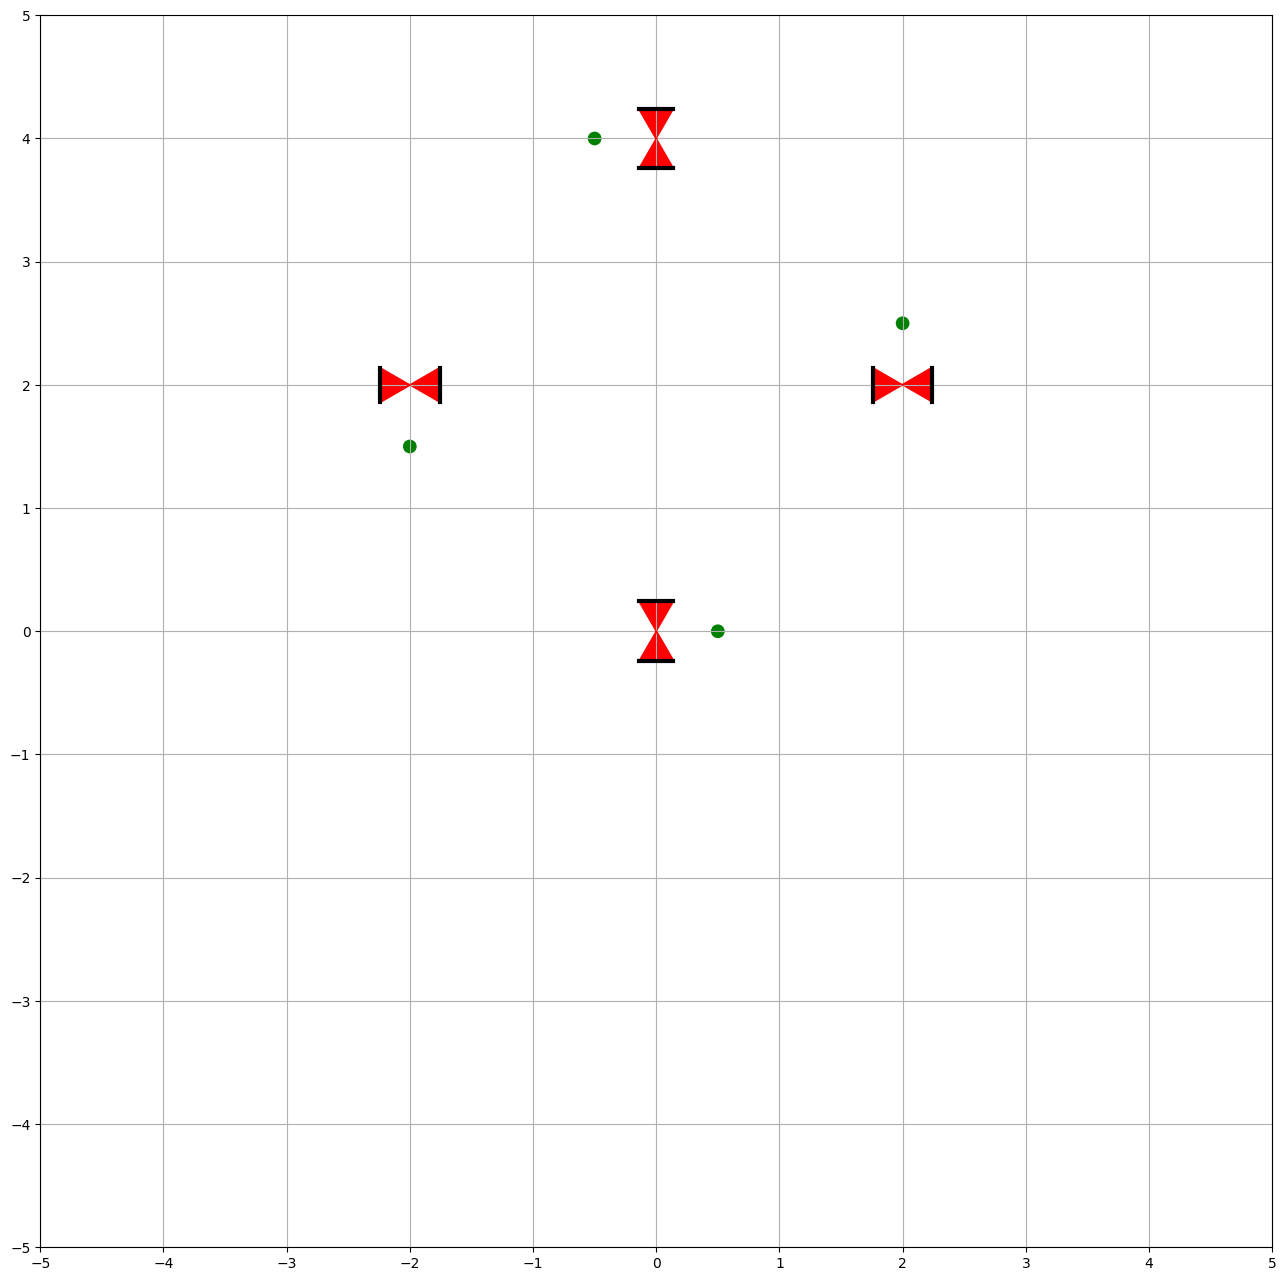

In [5]:
draw_arena(-5, 5, -5, 5)
draw_scooter(0,0,0)
draw_scooter(2,2,pi/2)
draw_scooter(0,4,pi)
draw_scooter(-2,2,3*pi/2)

plt.show

### Kinematic Modeling

We assume that we can control the wheels angular velocities $\omega_l = \dot{\phi}_l$ and $\omega_r = \dot{\phi}_r$ (this is a *kinematic* model of the wheelchair).
We also assume that the wheelchair fixed wheels roll without slipping. 

🧩 Establish the differential equations that relate $\dot{x}$,
$\dot{y}$ and $\dot{\theta}$ with $\omega_l$ and $\omega_r$.

$P_{r}$ : Centre de la roue droite \\
$Q_{r}$ : Point de contact de la roue droite avec le sol \\
$P_{l}$ : Centre de la roue gauche \\
$Q_{l}$ : Point de contact de la roue gauche avec le sol \\

Pour la roue droite, on a : \\

$\overrightarrow{V_{Q_{r}}} = \overrightarrow{V_{P_{r}}} + \overrightarrow{Ω_{r}} \wedge \overrightarrow{P_{r}Q_{r}} = \overrightarrow{0}  $ \\
Car le roulement se fait sans glissement \\
Alors : \\
$ \dot{x_{r}} \overrightarrow{x} + \dot{y_{r}} \overrightarrow{y}  + \left[ \dot{θ} \overrightarrow{z} + ω_{r} \left( \overrightarrow{x} sin(θ) - \overrightarrow{y}cos(θ) \right) \right] \wedge \left( -\overrightarrow{r}\overrightarrow{z} \right)  $ \\

Donc: \\
$ \left( \dot{x_{r}} + r\omega_{r}cos(\theta)  \right) \overrightarrow{x} + \left( \dot{y_{r}} + r\omega_{r}sin(\theta)\overrightarrow{y}  \right) = \overrightarrow{0}  $ \\
$$
\Rightarrow \dot{x}{r} = - r\omega{r}\cos(\theta) \\
\dot{y}{r} = - r\omega{r}\sin(\theta)
$$
### Le système étudié : {Scooter control} } 
On pose : \\
* $(x,y)$ les cordonnées du centre du scooter control \\
* $(x_{r},y_{r})$ les cordonnées du centre de la roue droite \\
* $(x_{l},y_{l})$ les cordonnées du centre de la roue gauche \\
Alors :
$ x_{r} = x + \dfrac{l}{2}sin(\theta) \\ 
 y_{r} = y - \dfrac{l}{2}cos(\theta) $ \\
 et \\
$ x_{l} = x + \dfrac{l}{2}sin(\theta) \\ 
 y_{l} = y - \dfrac{l}{2}cos(\theta) $ \\

### Analysis

🧩 Show that if $\omega_l$ and $\omega_r$ are continuously differentiable functions of $(x, y, \theta)$ (which includes the case of constant inputs), this system is well-posed.

**TODO**

🧩 Show that if $\omega_l$ and $\omega_r$ are constants, the maximal solution associated to any initial state is global. Is is still true of $\omega_l$ and $\omega_r$ are arbitrary continuously differentiable functions of $(x, y, \theta)$ ?

**TODO**

### Vector Field

In the sequel, `omega` is a function that computes the input vector $\omega := (\omega_l, \omega_r)$ given the time $t$ and $(x, y, \theta)$ (thus, it may depend on the time and/or on the system state if needed). For example:

In [6]:
def omega(t, xytheta):
    omega_l = (1 - l/4) * pi / r
    omega_r = (1 + l/4) * pi / r
    return array([omega_l, omega_r])

🧩 Implement a function `fun(t, xytheta)` that computes $(\dot{x}, \dot{y}, \dot{\theta})$ given the time $t$ and $(x,y,\theta)$ (and implicitly the inputs $\omega$ computed by the function `omega`).

In [7]:
def fun(t, xytheta):
    
    x, y ,theta = xytheta
    w=omega(t,xytheta)

    x_ = 1/2 * r * (w[0] - w[1]) *cos(theta)
    y_ = 1/2 * r * (w[0] - w[1]) *sin(theta)
    theta_ = -r (w[0] - w[1])
 
    return array([x_,y_,theta_])

### Simulation Setup

🧩 Simulate the wheelchair dynamics for 4 seconds when $(x_0, y_0, \theta_0)(t=0) = (0.0, 0.0, 0.0)$,
and the wheels velocities are the constants $\omega_l = (1 - \ell/4)  \pi / r \mbox{ rad/s}$ and $\omega_r = (1 + \ell/4)  \pi / r \mbox{ rad/s}$.
(Compute the dense outputs.)
   

In [8]:
pass

🧩 Use the simulation results to draw the graphs of $x(t)$, $y(t)$ and $\theta(t)$.

In [9]:
pass

🧩 Use the simulation results to display the robot location every 0.5 second.

In [10]:
pass

🧩 What should be the analytical expression of $x(t)$, $y(t)$ and $\theta(t)$? 

**TODO**

🧩 Do you experimental results match the theoretical results ? Draw the curves of the simulation error at time $t$ for $x$, $y$ and $\theta$.

In [11]:
pass

🧩 If needed, adjust the simulation parameters the simulated position error is less than $1\, \mathrm{ mm}$. 

In [12]:
pass